# Демодуляция. 
# Double Sideband Suppressed Carrier 
# (AM-DSB-SC)

## 1. Когерентная демодуляция
Рассмотрим когерентный способ демодуляции АМ-сигнала с подавленной несущей. Для этого принятый сигнал нужно смешать (перемножить) с колебанием, которое является копией несущей. Затем результат необходимо пропустить через фильтр нижних частот (ФНЧ). Схема когерентного демодулятора представлена ниже:

<img src="../../images/DSB_TC_Receiver_1_1.png" width=450/>

В аналитическом виде описанные выше преобразования можно представить следующим образом. Пусть принятый АМ-сигнал имеет вид:

$$s_{\textrm{am}} \left(t\right)=m\left(t\right)\cdot \cos \left(2\pi f_c t\right),$$

где $m\left(t\right)$ - информационное сообщение, $f_c$ - частота несущей.

После перемножения с гармоничеким сигналом, частота и фаза которого совпадают с несущей, получим:

$$s_{\textrm{mix}} \left(t\right)=m\left(t\right) \cdot \cos \left(2\pi f_c t\right)\cdot \cos \left(2\pi f_c t\right).$$

Вспомнив правило произведения косинусов, можем записать результат умножения в виде:

$$s_{\textrm{mix}} \left(t\right)=\frac{1}{2}m\left(t\right)+\frac{1}{2}m\left(t\right) \cdot \cos \left(2\pi \cdot 2f_c \cdot t\right).$$

Таким образом, сигнал на выходе смесителя явялется суммой инфомационного сообщения и сигнала на удвоенной частоте несущей $2f_c$. После пропускания данной суммы через ФНЧ, второе слагаемое исчезнет, и мы получим:

$$s_{\textrm{LPF}} \left(t\right)=\frac{1}{2}m\left(t\right).$$

То есть восстановленный сигнал является масштабированной копией исходного сообщения. 

Сложность при таком методе демодуляции заключается в том, что колебание в смесителе должно точно совпадать по частоте и фазе с несущей. Очевидно, что на практике генераторы на передающей и приемной сторонах не могут быть абсолютно идентичными. Между ними всегда есть некоторая расстройка. Рассмотрим вляние такого рассогласования на качество  демодуляции. Пусть рассогласование по частоте и фазе между колебанием в смесителе и несущей равны $\Delta f$ и $\Delta \phi$ соотвветственно. В этом случае на выходе смесителя получим:

$$\begin{array}{l}
s_{\textrm{mix}} \left(t\right)=m\left(t\right)\cdot \cos \left(2\pi f_c t\right)\cdot \cos \left(2\pi \left(f_c +\Delta f\right)t+\Delta \phi \right)=\\
=\frac{1}{2}\left(t\right)\cdot \cos \left(2\pi \Delta \textrm{ft}+\Delta \phi \right)+\textrm{слагаемое}\;с\;\textrm{удвоенной}\;\textrm{частотой}\ldotp 
\end{array}$$

После ФНЧ слагаемое на удвоенной частоте исчезнет:

$$s_{\textrm{LPF}} \left(t\right)=\frac{1}{2}m\left(t\right) \cdot \cos \left(2\pi \Delta \textrm{ft}+\Delta \phi \right).$$

Для начала рассмотрим случай, когда присутствует только расстройка по фазе ($\Delta \textrm{ft}=0$). Восстановленный сигнал примет вид:

$$s_{\textrm{LPF}} \left(t\right)=\frac{1}{2}m\left(t\right) \cdot \cos \left(\Delta \phi \right).$$

Результат совпадает со случаем идеальной демодуляции за исключение того, что теперь присутствует дополнительное масштабирование на $\cos \left(\Delta \phi \right)$. Так как модуль косинуса меньше единицы, мы получаем дополнительное ослабление сигнала. В крайнем случае, когда $\Delta \phi =90$ градусов, сигнал на выходе ФНЧ будет равен нулю.

Теперь рассмотрим, к чему приведет ненулевая расстройка по частоте. На выходе ФНЧ получим:  

$$s_{\textrm{LPF}} \left(t\right)=\frac{1}{2}m\left(t\right) \cdot \cos \left(2\pi \Delta \textrm{ft}\right).$$

Таким образом, восстановленное сообщение масштабируется на множитель $\cos \left(2\pi \Delta \textrm{ft}\right)$, амплитуда которого будет изменяться с частотой $\Delta f$. Ниже представлен скрипт, который демонстрирует когерентный метод демодуляции для аудиосообщения на несущей частоте 60кГц. С помощью переменных freq_offset и phase_offset можно задать расстройку по частоте и фазе и на слух оценить оскажения сигнала. 


<IPython.core.display.Javascript object>


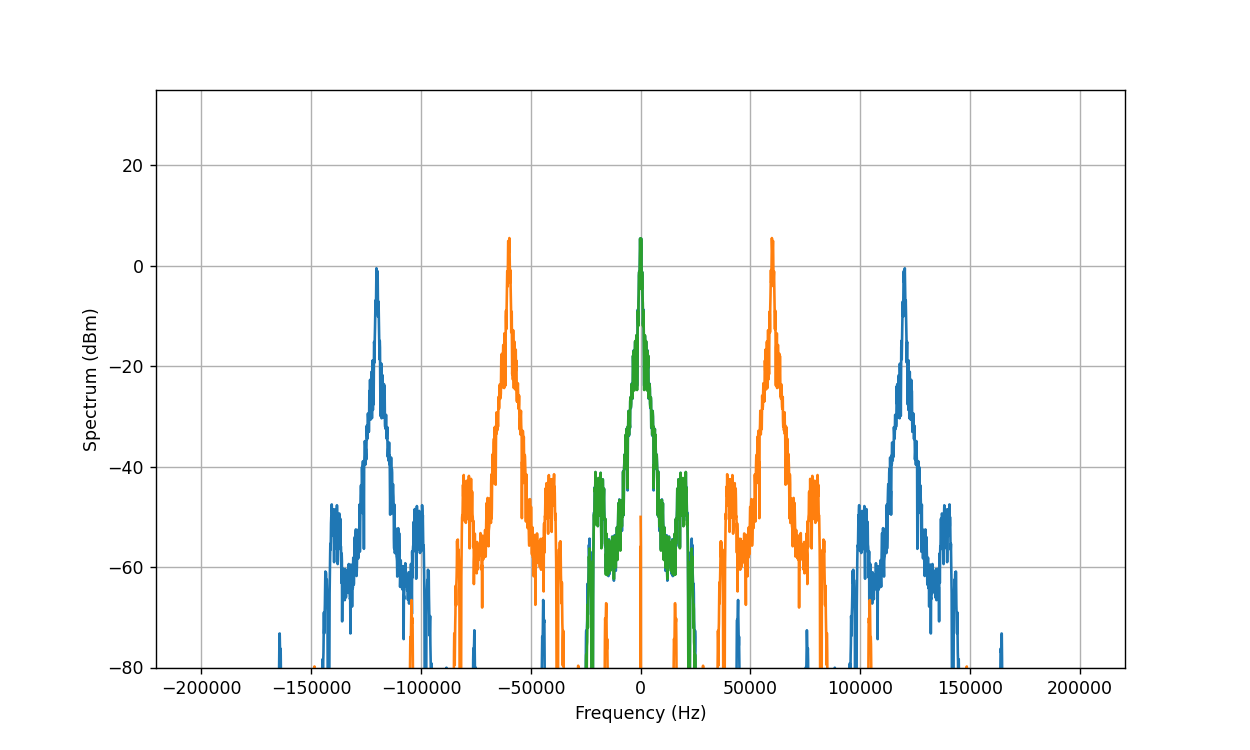

In [1]:
%matplotlib notebook
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import welch, resample_poly, firls, lfilter

audio_frame_size = 1000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 500      # число обрабатываемых пачек данных
rate_ratio = 10          # коэффициент увеличения частоты дискретизации
audio_amp = 0.1          # коэффициент усиления аудиосигнала
Fc = 60e3                # частота несущей

freq_offset = 0               # расстройка по частоте (Hz)
phase_offset = 0 * np.pi/180  # расстройка по фазе (градусы)

# открываем файл и получаем частоту дискретизации
audio_file = wave.open('../../wav/Audio_Source.wav')
audio_fs = audio_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
signal_fs = audio_fs * rate_ratio
signal_frame_size = audio_frame_size * rate_ratio

# получение коэффициентов ФНЧ
H = firls(175, (0, 20e3, 30e3, signal_fs/2), (1, 1, 0, 0), fs=signal_fs)

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-80, 35)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(3):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

message = []
FIR_tap_values = np.zeros(len(H) - 1) # внутреннее состояние ФНЧ

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    am_signal = audio_file.readframes(audio_frame_size)      # считываем отсчеты
    am_signal = np.frombuffer(am_signal, dtype=np.int16)     # преобразуем тип данных из byte в int16
    am_signal = np.reshape(am_signal, (-1, 2))               # разделяем отсчеты для правого и левого канала
    am_signal = am_signal[:,0] / 2**15                       # выделяем один канал и нормируем отсчеты к единице
    
    # МОДУЛЯЦИЯ
    # увеличиваем частоту дискретизации
    upsampled_data = resample_poly(am_signal, rate_ratio, 1)
    
    # несущий сигнал
    # частота несущей: 60 kHz
    carrier = np.cos(2 * np.pi * Fc * t)
    
    # амплитудная модуляция
    am_signal = upsampled_data * carrier
    
    # ДЕМОДУЛЯЦИЯ
    # формируем несущую с возможными ошибками
    demod_carrier = np.cos(2 * np.pi * (Fc + freq_offset) * t + phase_offset)
    
    # смешивание АМ-сигнала и несущей
    mixed_signal = am_signal * demod_carrier;
    
    # фильтрация сигнала
    baseband_signal, FIR_tap_values = lfilter(H, 1.0, np.real(mixed_signal), zi=FIR_tap_values)
    baseband_signal = baseband_signal - baseband_signal.mean()
    
    # построение спектрограмм
    signals = mixed_signal, am_signal, baseband_signal
    
    for i in range(3):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=4096) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # уменьшение частоты дискретизации
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

sounddevice.play(message * audio_amp, audio_fs, blocking=True)



Выше представлены преобразования в частотной области. Оранжевым обозначен спектр принимаемого АМ-сигнала. Синим - спектр на выходе смесителя. Можно увидеть, что он состоит из информационного сообщения и сигнала на удвоенной частоте несущей. После фильтрации остается только информационное сообщение (зеленый).

На слух можно оценить искажения аудиосигнала из-за рассогласования по фазе и частоте. При расстройке по фазе сигнал слышится слабее, но он не искажен. Расстройка по частоте приводит к ухудшению качества и появлению свистящих звуков.


## 2. Когерентная демодуляция при квадратурном приеме




В случае, когда прием АМ-сигнала осуществляется квадратурным способом (например почти во всех SDR  приемниках), структуру когерентного демодулятора можно упростить:

<img src="../../images/DSB_TC_Receiver_1_2.png" width=450/>

То есть, принятый АМ-сигнал, который является комплексным, нужно умножить на мнимую экспоненту, а потом просто выделить действительную часть.

В аналитическом виде описанные выше преобразования можно представить следующим образом. Пусть принятый АМ-сигнал имеет вид:

$$s_{\textrm{am}} \left(t\right)=m\left(t\right) \cdot e^{2\pi f_c t},$$

где, как и ранее, $m\left(t\right)$ - информационное сообщение, $f_c$ - частота несущей.

После умножения на мнимую экспоненту, частота и фаза которой совпадает с несущей получим:

$$s_{\textrm{mix}} \left(t\right)=m\left(t\right) \cdot e^{2\pi f_c t} \cdot e^{-2\pi f_c t} =m\left(t\right).$$

В идеале сигнал после умножения получится действительным и будет состоять только из информационного сообщения. Поэтому выделение действительной части не внесет в сигнал никаких изменений: 

$$\textrm{Re}\left\lbrace s_{\textrm{mix}} \left(t\right)\right\rbrace =m\left(t\right).$$

Теперь рассмотрим, что произойдет при наличие раастройки по фазе и частоте. Сигнал на выходе смесителя можно представить в виде:

$$s_{\textrm{mix}} \left(t\right)=m\left(t\right)\cdot e^{2\pi f_c t} \cdot e^{-2\pi \left(f_c +\Delta f\right)t-\Delta \phi } =m\left(t\right)\cdot e^{-2\pi \Delta \textrm{ft}-\Delta \phi }.$$

После вычисления действительной части получим:

$$\textrm{Re}\left\lbrace s_{\textrm{mix}} \left(t\right)\right\rbrace =m\left(t\right) \cdot \cos \left(2\pi \Delta \textrm{ft}+\Delta \phi \right).$$

Данный результат совпадает с формулой, полученной в предыдущем разделе. Соответственно наличие расстройки по частоте и фазе будет приводить к аналогиным искажениям.

Ниже представлен скрипт для реализации когерентной демодуляции в случае квадратурного приема. С помощью переменных freq_offset и phase_offset можно задать расстройку по частоте и фазе и на слух оценить оскажения сигнала.


<IPython.core.display.Javascript object>


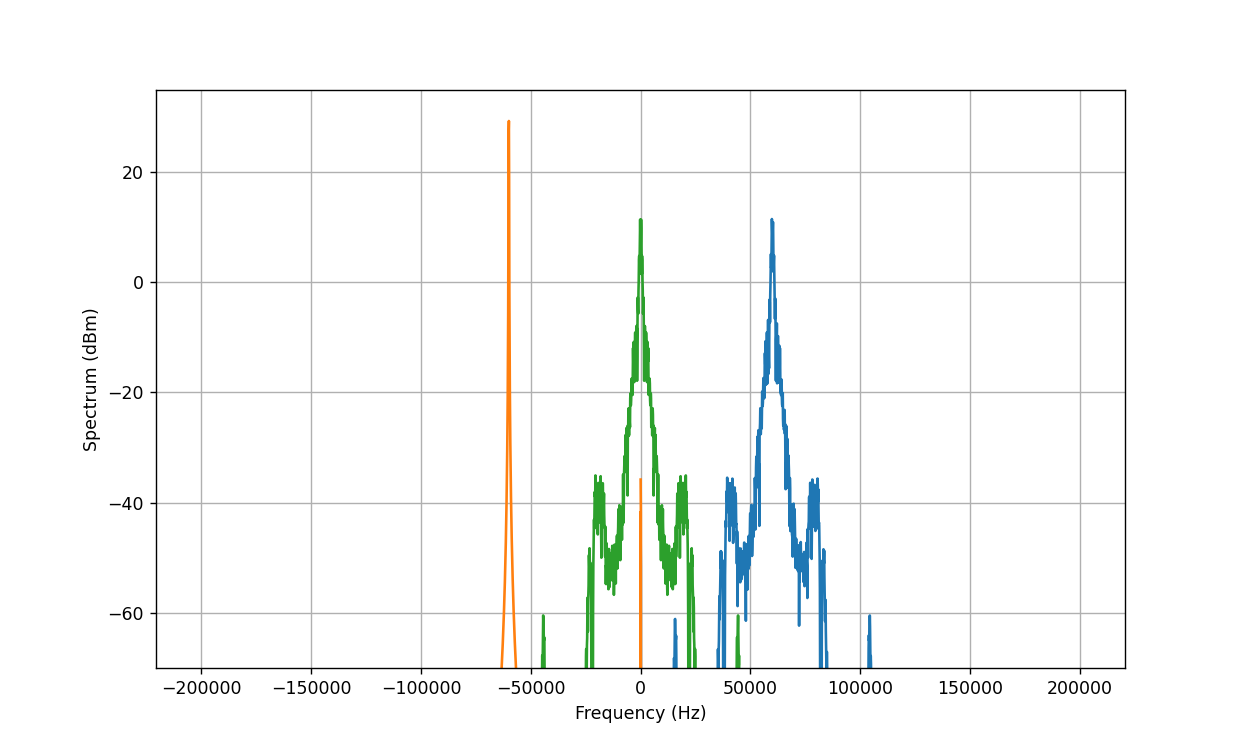

In [2]:
%matplotlib notebook
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import welch, resample_poly

audio_frame_size = 1000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 500      # число обрабатываемых пачек данных
rate_ratio = 10          # коэффициент увеличения частоты дискретизации
audio_amp = 0.1          # коэффициент усиления аудиосигнала
Fc = 60e3                # частота несущей

freq_offset = 0               # расстройка по частоте (Hz)
phase_offset = 0 * np.pi/180  # расстройка по фазе (градусы)

# открываем файл и получаем частоту дискретизации
audio_file = wave.open('../../wav/Audio_Source.wav')
audio_fs = audio_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
signal_fs = audio_fs * rate_ratio
signal_frame_size = audio_frame_size * rate_ratio

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-70, 35)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(3):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

message = []

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    am_signal = audio_file.readframes(audio_frame_size)      # считываем отсчеты
    am_signal = np.frombuffer(am_signal, dtype=np.int16)     # преобразуем тип данных из byte в int16
    am_signal = np.reshape(am_signal, (-1, 2))               # разделяем отсчеты для правого и левого канала
    am_signal = am_signal[:,0] / 2**15                       # выделяем один канал и нормируем отсчеты к единице
    
    # МОДУЛЯЦИЯ
    # увеличиваем частоту дискретизации
    upsampled_data = resample_poly(am_signal, rate_ratio, 1)
    
    # несущий сигнал
    # частота несущей: 60 kHz
    carrier = np.exp(1j * 2 * np.pi * Fc * t)
    
    # амплитудная модуляция
    am_signal = upsampled_data * carrier
    
    # ДЕМОДУЛЯЦИЯ
    # формируем несущую с возможными ошибками
    demod_carrier = np.exp(-1j * 2 * np.pi * (Fc + freq_offset) * t + phase_offset)
    
    # смешивание АМ-сигнала и несущей и выделение действительной части
    baseband_signal = np.real(am_signal * demod_carrier);
    baseband_signal = baseband_signal - baseband_signal.mean()
    
    # построение спектрограмм
    signals = am_signal, demod_carrier, baseband_signal
    
    for i in range(3):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=4096) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # уменьшение частоты дискретизации
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

sounddevice.play(message * audio_amp, audio_fs, blocking=True)

Выше представлены преобразования в частотной области. Синим обозначен спектр принимаемого АМ-сигнала. Так как прием квадратурный, спектр сигнала комплексный и расположен только в положительной области частот. Оранжевым цветом представлена мнимая экспонента, а зеленым - сигнал на выходе смесителя. 




## Литература:
- B. P. Lathi Modern Digital and Analog Communication Systems 
- R. Stewart, K. Barlee, D. Atkinson, L. Crockett Software Defined Radio using MATLAB® & Simulink and the RTL-SDR